# XgBoost
OUr first modelling attemps with logistic regressions saw moderate success however further modeling with more complex archetecture could yield further results. As such an Xg Boost will be trained next
- Based on our logistic regression the following variables gave us a good balance of infomrtion and size (due to the size of the dataset having too many variables quickly increases model training time and chance of overfitting
- cat_features = ['category']
- num_features = ['amt', 'trans_hour', 'time_since_last', 'last_amt']

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import joblib
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint


In [3]:
df = pd.read_csv('modeling_df.csv')
print(df.shape)
print(df.columns)

(1852385, 8)
Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'is_fraud',
       'trans_hour', 'time_since_last', 'last_amt'],
      dtype='object')


### Ensuring no data leaks in our engineered features
this is a leakage audit for two engineered features: time_since_last and last_amt. It recomputes them using only past info, compares to what’s in your dataframe, and flags places where your features look like they accidentally used future info.

In [4]:

time_col   = "trans_date_trans_time"
entity_col = "cc_num"
amt_col    = "amt"
feat_time  = "time_since_last"
feat_amt   = "last_amt"

# Set default values for inital transactions
SENTINEL_TIME = -1.0
SENTINEL_AMT  =  0.0   

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df_sorted = df.sort_values([entity_col, time_col]).reset_index(drop=True)

prev_amt = df_sorted.groupby(entity_col, sort=False)[amt_col].shift(1)
prev_dt  = df_sorted.groupby(entity_col, sort=False)[time_col].diff().dt.total_seconds()

next_amt = df_sorted.groupby(entity_col, sort=False)[amt_col].shift(-1)
next_dt  = (df_sorted.groupby(entity_col, sort=False)[time_col].shift(-1) - df_sorted[time_col]).dt.total_seconds()

df_sorted["last_amt_check"]            = prev_amt
df_sorted["time_since_last_check"]     = prev_dt
df_sorted["next_amt_for_suspect"]      = next_amt
df_sorted["next_dt_for_suspect_secs"]  = next_dt

amt_ok = (
    np.isclose(df_sorted[feat_amt].astype(float), df_sorted["last_amt_check"], atol=1e-12)
    | ((df_sorted[feat_amt] == SENTINEL_AMT) & df_sorted["last_amt_check"].isna())
)
time_ok = (
    np.isclose(df_sorted[feat_time].astype(float), df_sorted["time_since_last_check"], atol=1e-6)
    | ((df_sorted[feat_time] == SENTINEL_TIME) & df_sorted["time_since_last_check"].isna())
)

bad_amt  = ~amt_ok
bad_time = ~time_ok

n = len(df_sorted)
print(f"{feat_amt} mismatches:  {bad_amt.sum():,} / {n:,}  ({bad_amt.mean():.3%})")
print(f"{feat_time} mismatches: {bad_time.sum():,} / {n:,}  ({bad_time.mean():.3%})")

suspect_amt_forward  = bad_amt  & np.isclose(df_sorted[feat_amt], df_sorted["next_amt_for_suspect"], atol=1e-12)
suspect_time_forward = bad_time & np.isclose(
    df_sorted[feat_time],
    df_sorted["next_dt_for_suspect_secs"].fillna(SENTINEL_TIME),
    atol=1e-6
)

print("\nPossible look-ahead matches (feature equals NEXT event):")
print("  last_amt        :", int(suspect_amt_forward.sum()))
print("  time_since_last :", int(suspect_time_forward.sum()))

# time must be non-decreasing within card
dt_step = df_sorted.groupby(entity_col, sort=False)[time_col].diff().dt.total_seconds()
bad_order = (dt_step < 0).sum()
print("\nWithin-card back-in-time jumps:", int(bad_order))

# first row per card should use sentinels
first_mask = df_sorted.groupby(entity_col, sort=False).cumcount() == 0
bad_first_amt  = (df_sorted.loc[first_mask, feat_amt]  != SENTINEL_AMT).sum()
bad_first_time = (df_sorted.loc[first_mask, feat_time] != SENTINEL_TIME).sum()
print("First rows without proper sentinels — last_amt:", int(bad_first_amt),
      " time_since_last:", int(bad_first_time))

# non-first rows should have non-negative time deltas
neg_time = ((~first_mask) & (df_sorted[feat_time] < 0)).sum()
print("Non-first rows with negative time_since_last:", int(neg_time))

cols_show = [entity_col, time_col, amt_col,
             feat_amt, "last_amt_check", "next_amt_for_suspect",
             feat_time, "time_since_last_check", "next_dt_for_suspect_secs"]
offenders = df_sorted.loc[bad_amt | bad_time, cols_show].head(20)
if len(offenders):
    display(offenders)
else:
    print("\nNo mismatches shown — engineered features look consistent with past-only computation.")


last_amt mismatches:  0 / 1,852,385  (0.000%)
time_since_last mismatches: 0 / 1,852,385  (0.000%)

Possible look-ahead matches (feature equals NEXT event):
  last_amt        : 0
  time_since_last : 0

Within-card back-in-time jumps: 0
First rows without proper sentinels — last_amt: 0  time_since_last: 0
Non-first rows with negative time_since_last: 0

No mismatches shown — engineered features look consistent with past-only computation.


Fix any leaked data

In [5]:
TIME = "trans_date_trans_time"
ID   = "cc_num"
AMT  = "amt"

SENTINEL_TIME = -1.0
SENTINEL_AMT  =  0.0

# Keep original row order
idx = df.index

# Sort by (card, time) to compute past-only features
g = df.sort_values([ID, TIME]).groupby(ID, sort=False)

last_amt_fix       = g[AMT].shift(1).reindex(df.sort_values([ID, TIME]).index)
time_since_fix_sec = g[TIME].diff().dt.total_seconds().reindex(df.sort_values([ID, TIME]).index)

# Map back to original order
rev = df.sort_values([ID, TIME]).index
last_amt_fix       = pd.Series(last_amt_fix.values, index=rev).reindex(idx)
time_since_fix_sec = pd.Series(time_since_fix_sec.values, index=rev).reindex(idx)

# Fill first rows per card with your sentinels
first_mask = g.cumcount().reindex(rev).reindex(idx).eq(0)
last_amt_fix       = last_amt_fix.where(~first_mask, SENTINEL_AMT)
time_since_fix_sec = time_since_fix_sec.where(~first_mask, SENTINEL_TIME)

# Replace only where incorrect
mask_last  = ~np.isclose(df["last_amt"].astype(float),       last_amt_fix,       atol=1e-12)
mask_time  = ~np.isclose(df["time_since_last"].astype(float), time_since_fix_sec, atol=1e-6) | (df["time_since_last"] < 0)

df.loc[mask_last, "last_amt"]         = last_amt_fix[mask_last]
df.loc[mask_time, "time_since_last"]  = time_since_fix_sec[mask_time]

print("Patched rows — last_amt:", int(mask_last.sum()), " time_since_last:", int(mask_time.sum()))

Patched rows — last_amt: 0  time_since_last: 998


In [6]:
df.to_csv("modeling_df.csv", index=False)

# Xg model
This XgBoost model is optimised using a time series cross validation split to optimise model hyperparameters. To handel the class imbalance the loss of missclassifying fraud is increased by neg / pos (i.e., the ratio of negatives per positive).
- Data prep:

In [7]:
Xg_df = df.sort_values('trans_date_trans_time').reset_index(drop=True)
Xg_df = Xg_df.drop(columns=['trans_date_trans_time', 'cc_num'], axis=1)
# 2) Time-based split (e.g., last 20% as test)
split_idx = int(len(df) * 0.80)
train_XG = Xg_df.iloc[:split_idx]
test_XG  = Xg_df.iloc[split_idx:]

print(train_XG.shape)
print(test_XG.shape)

(1481908, 6)
(370477, 6)


In [8]:
Xg_train_y = train_XG['is_fraud']
Xg_train_x = train_XG.drop(columns=['is_fraud'], axis=1)

Xg_test_y = test_XG['is_fraud']
Xg_test_x = test_XG.drop(columns=['is_fraud'], axis=1)

print(Xg_test_x.columns)

Index(['category', 'amt', 'trans_hour', 'time_since_last', 'last_amt'], dtype='object')


In [9]:
# Pipelines
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
    #('scaler', StandardScaler)
])

cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

cat_features = ['category']
num_features = ['amt', 'trans_hour', 'time_since_last', 'last_amt']

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Increased weight on fradulent transactions to deal with the class imbalance
neg, pos = (Xg_train_y == 0).sum(), (Xg_train_y == 1).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))
xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="aucpr",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

To optimise model parameters we will use the included TimeSeriesSplit function from sklearn

In [21]:
tscv = TimeSeriesSplit(n_splits=5, gap=0)

#Parameter search space
param_distributions = {
    "model__n_estimators": randint(300, 1500),
    "model__learning_rate": loguniform(0.02, 0.2),
    "model__max_depth": randint(3, 10),
    "model__min_child_weight": randint(1, 10),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4), 
    "model__gamma": uniform(0.0, 5.0),
    "model__reg_lambda": uniform(1.0, 20.0),
    "model__reg_alpha": uniform(0.0, 10.0),
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="average_precision",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)



In [22]:
# Next we fit the data to our cross validation grid search to find the best model parameters
search.fit(Xg_train_x, Xg_train_y)

print("Best AP score:", search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print("  ", k, "=", v)
    

best_model = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AP score: 0.9444825433267183
Best params:
   model__colsample_bytree = 0.6201174559367771
   model__gamma = 1.8832554720047896
   model__learning_rate = 0.048166282945258106
   model__max_depth = 9
   model__min_child_weight = 9
   model__n_estimators = 1398
   model__reg_alpha = 3.5219803300806363
   model__reg_lambda = 6.990321852182778
   model__subsample = 0.9471076968546378


Evaluating the model with the best hyper-parameters

In [16]:
# Fitting the best model on test set and evaluating the precision, recall, f1 and comfustion matrix

final_model = search.best_estimator_
p_test = final_model.predict_proba(Xg_test_x)[:, 1] # get Y-hat

threshold = 0.5
y_pred = (p_test >= threshold).astype(int)

# 3) Metrics
ap  = average_precision_score(Xg_test_y, p_test)
roc = roc_auc_score(Xg_test_y, p_test)
prec = precision_score(Xg_test_y, y_pred, zero_division=0)
rec  = recall_score(Xg_test_y, y_pred)

cm = confusion_matrix(Xg_test_y, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

print(f"Average Precision (PR AUC): {ap:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Precision @ {threshold:.2f}: {prec:.4f}")
print(f"Recall    @ {threshold:.2f}: {rec:.4f}")
print("\nConfusion matrix:")
display(cm_df)

NameError: name 'search' is not defined

Next we will use the best parameters and train the model on the full training dataset

### Final XgBoost
Note this model is the same as above - but is redone so that I don't have to re-run the gridsearch to use the model

In [14]:
xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="aucpr",
    n_jobs=-1,
    random_state=42,
)

# Same  preprocessor as before
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb),
])

best_params = {
    # Retrieved from CV grid search

    "model__colsample_bytree": 0.6201174559367771,
    "model__gamma": 1.8832554720047896,
    "model__learning_rate": 0.048166282945258106,
    "model__max_depth": 9,
    "model__min_child_weight": 9,
    "model__n_estimators": 1398,
    "model__reg_alpha": 3.5219803300806363,
    "model__reg_lambda": 6.990321852182778,
    "model__subsample": 0.9471076968546378
}

# apply the tuned params
pipeline.set_params(**best_params)

# Increase the loss of fraudulent transactions
neg, pos = (Xg_train_y == 0).sum(), (Xg_train_y == 1).sum()
pipeline.set_params(model__scale_pos_weight=max(1.0, neg / max(1, pos)))


pipeline.fit(Xg_train_x, Xg_train_y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amt', 'trans_hour',
                                                   'time_since_last',
                                                   'last_amt']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['category'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byleve...
                               gamma=1.8832554720047896, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.048166282945258106, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=9, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1398, n_jobs=-1,
                               num_parallel_tree=None, ...))])

### Model Evaluation
- Evaluating the final model on the test set

In [15]:

final_model = pipeline
p_test = final_model.predict_proba(Xg_test_x)[:, 1]

threshold = 0.5
y_pred = (p_test >= threshold).astype(int)

ap  = average_precision_score(Xg_test_y, p_test)
roc = roc_auc_score(Xg_test_y, p_test)
prec = precision_score(Xg_test_y, y_pred, zero_division=0)
rec  = recall_score(Xg_test_y, y_pred)
cm   = confusion_matrix(Xg_test_y, y_pred)

print(f"Average Precision (PR AUC): {ap:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Precision @ {threshold:.2f}: {prec:.4f}")
print(f"Recall    @ {threshold:.2f}: {rec:.4f}")

pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])


Average Precision (PR AUC): 0.9399
ROC AUC: 0.9992
Precision @ 0.50: 0.5737
Recall    @ 0.50: 0.9526


,Pred 0,Pred 1
Actual 0,368173,955
Actual 1,64,1285


# Threshold Tuning

To select the best threshold for our model we will experiment with different threshold values

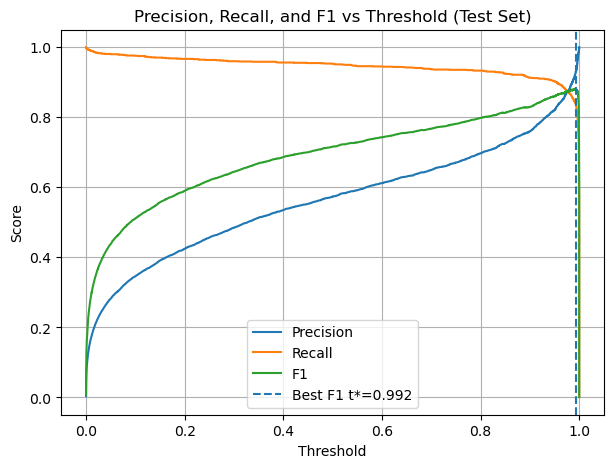

Best F1 on test ≈ 0.8822 at threshold t* = 0.9925


In [22]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# p_test is the probabiliteis from the model and precision_recall_curve computes the precision and recall for all thresholds
prec, rec, thr = precision_recall_curve(Xg_test_y, p_test)

# precision/recall have length len(thr)+1; align for plotting and F1
f1 = 2 * prec * rec / (prec + rec + 1e-8)

# Gets the threshold with the highest f1 score
best_idx = int(np.nanargmax(f1))
best_f1 = f1[best_idx]
best_thr = thr[min(best_idx, len(thr)-1)]

plt.figure(figsize=(7,5))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1],  label='Recall')
plt.plot(thr, f1[:-1],   label='F1')
plt.axvline(best_thr, ls='--', label=f'Best F1 t*={best_thr:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold (Test Set)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Best F1 on test ≈ {best_f1:.4f} at threshold t* = {best_thr:.4f}")

### Evaluation of the Optimal F1 Score

In [23]:
threshold = 0.9925
y_pred = (p_test >= threshold).astype(int)

ap  = average_precision_score(Xg_test_y, p_test)
roc = roc_auc_score(Xg_test_y, p_test)
prec = precision_score(Xg_test_y, y_pred, zero_division=0)
rec  = recall_score(Xg_test_y, y_pred)
cm   = confusion_matrix(Xg_test_y, y_pred)

print(f"Average Precision (PR AUC): {ap:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Precision @ {threshold:.2f}: {prec:.4f}")
print(f"Recall    @ {threshold:.2f}: {rec:.4f}")

pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])


Average Precision (PR AUC): 0.9399
ROC AUC: 0.9992
Precision @ 0.99: 0.9272
Recall    @ 0.99: 0.8399


,Pred 0,Pred 1
Actual 0,369039,89
Actual 1,216,1133


### Low threshold check - 0.3
At the optimal f1 score the model missclassifies a large number of fradulent cases, as such we will check how lowering the threshold impact peformance

In [27]:
threshold = 0.3
y_pred = (p_test >= threshold).astype(int)

ap  = average_precision_score(Xg_test_y, p_test)
roc = roc_auc_score(Xg_test_y, p_test)
prec = precision_score(Xg_test_y, y_pred, zero_division=0)
rec  = recall_score(Xg_test_y, y_pred)
cm   = confusion_matrix(Xg_test_y, y_pred)

print(f"Average Precision (PR AUC): {ap:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Precision @ {threshold:.2f}: {prec:.4f}")
print(f"Recall    @ {threshold:.2f}: {rec:.4f}")

pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])


Average Precision (PR AUC): 0.9399
ROC AUC: 0.9992
Precision @ 0.30: 0.4847
Recall    @ 0.30: 0.9600


,Pred 0,Pred 1
Actual 0,367751,1377
Actual 1,54,1295


### Final threshold - 0.7
a threshold of 0.7 seems to be a solid compromise between precision and recall however further tests will be done later on analysing the cost of false positives

In [30]:
threshold = 0.7
y_pred = (p_test >= threshold).astype(int)

ap  = average_precision_score(Xg_test_y, p_test)
roc = roc_auc_score(Xg_test_y, p_test)
prec = precision_score(Xg_test_y, y_pred, zero_division=0)
rec  = recall_score(Xg_test_y, y_pred)
cm   = confusion_matrix(Xg_test_y, y_pred)

print(f"Average Precision (PR AUC): {ap:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Precision @ {threshold:.2f}: {prec:.4f}")
print(f"Recall    @ {threshold:.2f}: {rec:.4f}")

pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])


Average Precision (PR AUC): 0.9399
ROC AUC: 0.9992
Precision @ 0.70: 0.6495
Recall    @ 0.70: 0.9370


,Pred 0,Pred 1
Actual 0,368446,682
Actual 1,85,1264


### Plotting ROC and precision-Recall curves

In [33]:
from sklearn.metrics import roc_curve

def plot_pr_with_point(y, p, t_star=None, title="Precision–Recall Curve"):
    prec, rec, thr = precision_recall_curve(y, p)
    pr_auc = average_precision_score(y, p)

    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.4f}")

    if t_star is not None:
        # find the nearest threshold index to t_star
        j = np.searchsorted(thr, t_star, side="left")
        j = np.clip(j, 0, len(prec)-1)  # align to PR arrays
        plt.scatter(rec[j], prec[j], s=60, marker='o', label=f"@ t*={t_star:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()
    return pr_auc

def plot_roc_with_point(y, p, t_star=None, title="ROC Curve"):
    fpr, tpr, thr = roc_curve(y, p)
    rocA = roc_auc_score(y, p)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {rocA:.4f}")
    plt.plot([0,1],[0,1], ls="--", c="gray")
    if t_star is not None:
        j = np.searchsorted(thr[::-1], t_star, side="left")
        jj = len(thr) - 1 - np.clip(j, 0, len(thr)-1)
        jj = np.clip(jj, 0, len(fpr)-1)
        plt.scatter(fpr[jj], tpr[jj], s=60, marker='o', label=f"@ t*={t_star:.3f}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()
    return rocA


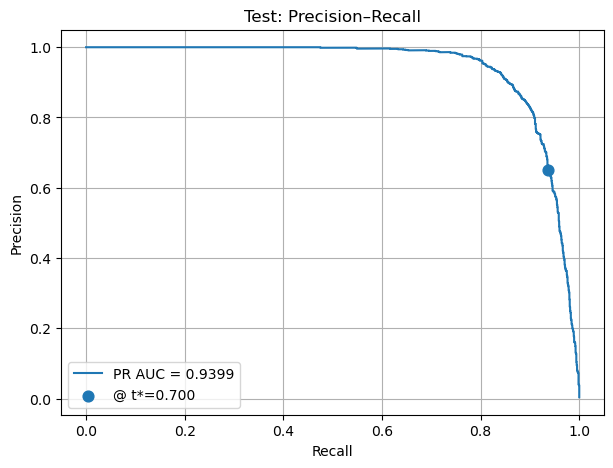

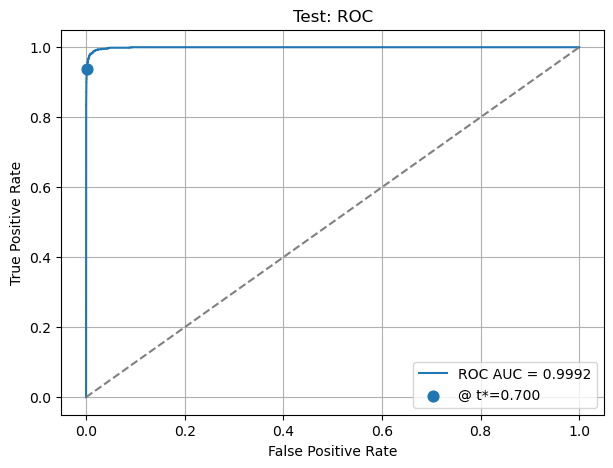

In [34]:

pr_auc_test  = plot_pr_with_point(Xg_test_y,  p_test, t_star=0.7, title="Test: Precision–Recall")
roc_auc_test = plot_roc_with_point(Xg_test_y, p_test, t_star=0.7, title="Test: ROC")
